100%|██████████| 18.2M/18.2M [00:16<00:00, 1.13MB/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 1.59MB/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 8.23MB/s]


Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw


Optimizer: Adam, Learning Rate: 0.001
Fold | Accuracy (%) | Training Time (s)
--------------------------------------
 1   | 94.71        | 138.62
 2   | 94.53        | 136.77
 3   | 94.95        | 139.98
 4   | 94.57        | 137.97
 5   | 94.40        | 138.14
--------------------------------------
 Avg | 94.63        | 138.29


Optimizer: Adam, Learning Rate: 0.0005
Fold | Accuracy (%) | Training Time (s)
--------------------------------------
 1   | 94.96        | 138.34
 2   | 94.54        | 137.20
 3   | 94.72        | 136.77
 4   | 94.48        | 137.62
 5   | 94.46        | 137.36
--------------------------------------
 Avg | 94.63        | 137.46


Optimizer: RMSprop, Learning Rate: 0.001
Fold | Accuracy (%) | Training Time (s)
--------------------------------------
 1   | 94.45        | 136.74
 2   | 94.48        | 135.44
 3   | 94.90        | 135.79
 4   | 94.69        | 135.90
 5   | 94.95        |

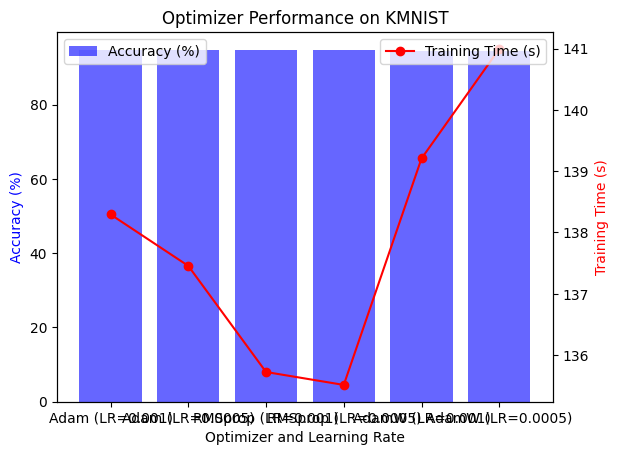

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import time
import matplotlib.pyplot as plt

# Define the feedforward neural network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], output_size=10):
        super(FeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size),
        )

    def forward(self, x):
        return self.model(x)

# Load KMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.KMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, transform=transform, download=True)

# Hyperparameters
batch_size = 64
epochs = 10
learning_rates = [0.001, 0.0005]
k_folds = 5
optimizers = {'Adam': optim.Adam, 'RMSprop': optim.RMSprop, 'AdamW': optim.AdamW}

# Prepare K-Fold Cross Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
results = {}

def train_and_evaluate(optimizer_name, learning_rate):
    fold_results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f'\nOptimizer: {optimizer_name}, Learning Rate: {learning_rate}')
    print("Fold | Accuracy (%) | Training Time (s)")
    print("--------------------------------------")

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = FeedForwardNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizers[optimizer_name](model.parameters(), lr=learning_rate)

        start_time = time.time()

        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        train_time = time.time() - start_time
        fold_results.append((accuracy, train_time))
        print(f' {fold+1}   | {accuracy:.2f}        | {train_time:.2f}')

    avg_accuracy = np.mean([res[0] for res in fold_results])
    avg_time = np.mean([res[1] for res in fold_results])
    results[(optimizer_name, learning_rate)] = (avg_accuracy, avg_time)
    print("--------------------------------------")
    print(f' Avg | {avg_accuracy:.2f}        | {avg_time:.2f}\n')

# Train and Evaluate for each optimizer and learning rate combination
for opt in optimizers:
    for lr in learning_rates:
        train_and_evaluate(opt, lr)

# Plot results
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
optim_names = [f'{k[0]} (LR={k[1]})' for k in results.keys()]
accuracies = [v[0] for v in results.values()]
times = [v[1] for v in results.values()]
ax1.bar(optim_names, accuracies, color='b', alpha=0.6, label='Accuracy (%)')
ax2.plot(optim_names, times, color='r', marker='o', label='Training Time (s)')
ax1.set_xlabel('Optimizer and Learning Rate')
ax1.set_ylabel('Accuracy (%)', color='b')
ax2.set_ylabel('Training Time (s)', color='r')
plt.xticks(rotation=45)
plt.title('Optimizer Performance on KMNIST')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


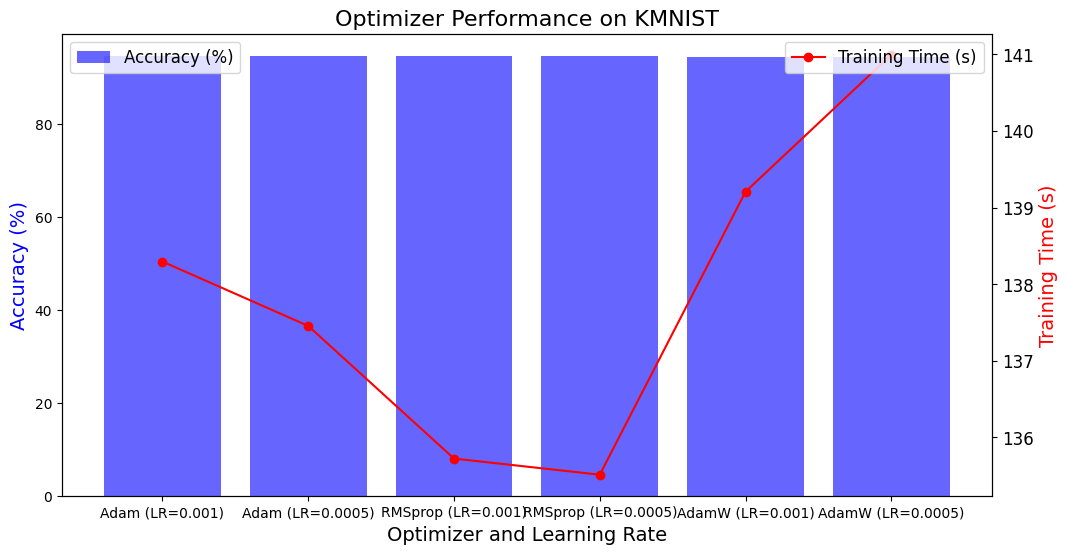

In [2]:
# Increase figure size
fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust width and height as needed
ax2 = ax1.twinx()

optim_names = [f'{k[0]} (LR={k[1]})' for k in results.keys()]
accuracies = [v[0] for v in results.values()]
times = [v[1] for v in results.values()]

ax1.bar(optim_names, accuracies, color='b', alpha=0.6, label='Accuracy (%)')
ax2.plot(optim_names, times, color='r', marker='o', label='Training Time (s)')

# Labels and Titles
ax1.set_xlabel('Optimizer and Learning Rate', fontsize=14)
ax1.set_ylabel('Accuracy (%)', color='b', fontsize=14)
ax2.set_ylabel('Training Time (s)', color='r', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for readability
plt.yticks(fontsize=12)
plt.title('Optimizer Performance on KMNIST', fontsize=16)

# Legends
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

plt.show()
